# SIR modell készítése
#### Anita és Ádám közös munkája  
Egy SIR-modell segítségével szeretnénk vizsgálni a járvány terjedésének alakulását. 

In [2]:
%matplotlib inline
import numpy as np
from scipy.integrate import odeint
import sympy as sym
from sympy.utilities.lambdify import implemented_function
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter
import seaborn as sns
#matplotlib.use('tkAgg')

Felírjuk a kérdéses közönséges differenciálegyenlet rendszert. Itt:  
  
$S(t)$ jelöli a társadalomban a fertőzhető egyének számát  
$I(t)$ jelöli a társadalomban a fertőzött egyének számát  
$R(t)$ jelöli a társadalomban a gyógyult egyének számát  
  
Az egyszerűség kedvéért feltesszük, hogy a társadalom zárt, azaz eltekintünk a bevándorló, kivándorló, születő, vagy elhalálozó egyének esetleges számától.

In [3]:
t = sym.symbols('t')
S = sym.Function('S')(t)
I = sym.Function('I')(t)
R = sym.Function('R')(t)
beta = sym.symbols(u'β')
gamma = sym.symbols(u'γ')
dSdt=sym.Derivative(S,t)
dIdt=sym.Derivative(I,t)
dRdt=sym.Derivative(R,t)

eq1=sym.Equality(dSdt, -beta * S * I)
eq2=sym.Equality(dIdt, beta * S * I - gamma * I)
eq3=sym.Equality(dRdt,  gamma * I)

display(eq1,eq2,eq3)

Eq(Derivative(S(t), t), -β*I(t)*S(t))

Eq(Derivative(I(t), t), β*I(t)*S(t) - γ*I(t))

Eq(Derivative(R(t), t), γ*I(t))

Felmerül a kérdés, hogy mit reprezentál $\beta$, illetve $\gamma$. Az egyenletrendszerünkben:  
$\beta$ az a paraméter, amely meghatározza, hogy egy egyénnek naponta hány olyan kontaktusban volt része átlagosan, ami fertőzést eredményezett,  
$\gamma$ meghatározza, hogy a fertőzött egyének várhatóan mekkora része gyógyul meg bármelyik napon (pl. ha a fertőzés időtartama 3 nap, akkor $\gamma = \frac{1}{3}$)  
Innen persze az is látható, hogy csak azt tekintjük fertőzöttnek, aki még fertőzni képes, azaz ha valaki beteg, nem biztos, hogy I(t) csoportba tartozik.

### SIR-modell megvalósítása

Az alábbi táblázat az EU országainak néhány adatát tartalmazza. Amire nekünk szükségünk lesz az $R_{0}$, valamint a $\Delta t$. Mivel 27 ország vizsgálata kissé időigényes lenne, így választottunk néhány reprezentáns országot, (valamint belevettük az EU-s átlagot is), amelyekre felállítjuk az SIR-modellt. 

In [12]:
pd.options.mode.chained_assignment = None

sir_data=pd.read_csv("sir_data.csv")
sir_countries=["Austria","Finland","Germany","Hungary","Ireland","European Union"]
sir_data=sir_data[sir_data["Country"].isin(sir_countries)]

display(sir_data)

,Country,Population,R0,Rt,t*,T,Δt
0,Austria,8.840.521,4.38±0.36,0.45±0.01,13.37±0.68,6.49±0.47,8.33±1.70
8,Finland,5.515.525,1.62±0.05,0.92±0.01,25.05±0.51,1.20±0.68,24.25±2.49
10,Germany,82.905.782,6.33±0.64,0.58±0.01,17.06±1.39,12.41±0.71,3.25±1.92
12,Hungary,9.775.564,1.97±0.55,0.37±0.15,25.62±6.55,20.23±7.33,31.67±1.89
13,Ireland,4.867.309,1.94±0.06,0.57±0.03,30.78±0.53,5.94±1.28,30.00±3.46
27,European Union,446.786.293,4.22±1.69,0.67±0.18,18.61±6.43,10.82±4.65,17.24±2.00


Mivel az egyenletrendszerünkhöz szükség van $\beta$ és $\gamma$ paraméterekre, így az alábbiakban meghatározzuk $\beta$-t a táblázat adataiból ($\gamma$ = $\frac{1}{\Delta t}$). A már emlegetett $R_{0}$ egy lehetséges számítási módja: $R_{0} = \frac{\beta}{\gamma}$. Ha (talán) meg tudjuk oldani az egylenletet $\beta$-ra, akkor az adatokból miden országnak meg tudunk adni egy megfelelő $\beta$-t.

In [11]:
sir_indexes=[sir_data[sir_data['Country'] == country].index[-1] for country in sir_countries]
for index in sir_indexes:
    sir_data['R0'][index]=float(sir_data['R0'][index][0:(sir_data['R0'][index]).find('±')])
for index in sir_indexes:
    sir_data['Δt'][index]=float(sir_data['Δt'][index][0:(sir_data['Δt'][index]).find('±')])
sir_data.insert(7, "Beta", [sir_data["R0"][index]/sir_data["Δt"][index] for index in sir_indexes], True)
for index in sir_indexes:
    temp=sir_data['Population'][index]
    sir_data['Population'][index]=int(temp.replace('.', '', temp.count('.')))
    
display(sir_data)

,Country,Population,R0,Rt,t*,T,Δt,Beta
0,Austria,8840521,4.38,0.45±0.01,13.37±0.68,6.49±0.47,8.33,0.525810
8,Finland,5515525,1.62,0.92±0.01,25.05±0.51,1.20±0.68,24.25,0.066804
10,Germany,82905782,6.33,0.58±0.01,17.06±1.39,12.41±0.71,3.25,1.947692
12,Hungary,9775564,1.97,0.37±0.15,25.62±6.55,20.23±7.33,31.67,0.062204
13,Ireland,4867309,1.94,0.57±0.03,30.78±0.53,5.94±1.28,30.0,0.064667
27,European Union,446786293,4.22,0.67±0.18,18.61±6.43,10.82±4.65,17.24,0.244780


Az alábbiakban a paraméterek ismeretében megadjuk a KDE-t függvény alakban.

In [5]:
def deriv(x, t, beta, gamma):
    s, i, r = x
    dsdt = -beta * s * i
    didt = beta * s * i - gamma * i
    drdt =  gamma * i
    return [dsdt, didt, drdt]

### Ábrázolás
Az ábrázoláshoz létrehozunk egy függvényt, ami adott országra megoldja az egyenletrendszert.


A (numerikus) megoldahtóság érdekében a társadalomban élők számát ($N$) egységnyinek tekintjük. Ekkor ha a járvány alakulását $t=0$ időpontból vizsgáljuk, akkor kezdetben:  
  
$s(t) = \frac{S(t)}{N} = 1$,  
$i(t) = \frac{I(t)}{N}$,  
$r(t) = \frac{R(t)}{N} = 0$  
  
A fertőzött egyének számát mi választottuk.

In [6]:
def sircountry(country: int, infected: int, days: int):
    beta = sir_data["Beta"][country]
    gamma = 1/sir_data["Δt"][country]
    I_initial = infected/sir_data["Population"][country]
    R_initial = 0
    S_initial = 1-R_initial-I_initial
    x_initial = S_initial, I_initial, R_initial
    t = np.linspace(0, days, days*12)
    sol = odeint(deriv, x_initial, t, args=(beta, gamma))
    s, i, r = sol.T*sir_data["Population"][country]
    
    return [s, i, r]
    

In [7]:
def millions(x, pos):
    return '{:.1f}M'.format(x/1000000)

# Apply formatter to y axis
formatter = FuncFormatter(millions)

Az általunk választott országokra hívva az előbb említett függvényt, megkaphatjuk, hogy az SIR-modell milyen becslést ad a járvány lefolyására, amit az ábrákból tudunk kikövetkeztetni.

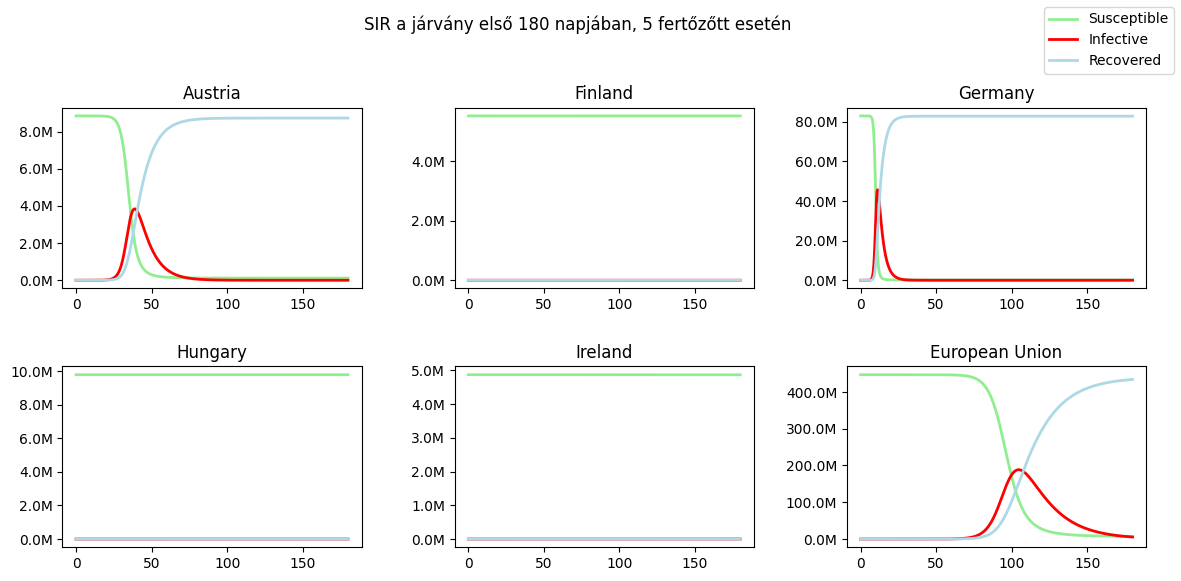

In [8]:
fig, axs = plt.subplots(2,3, figsize=(12,6))
counter=0
for i in range(0,2):
    for j in range(0,3):
        t = np.linspace(0, 180, 180*12)
        sir=sircountry(sir_indexes[counter],5,180)
        axs[i,j].plot(t, sir[0], lw=2, label='Susceptible', c='lightgreen')
        axs[i,j].plot(t, sir[1], lw=2, label='Infective', c='red')
        axs[i,j].plot(t, sir[2], lw=2, label='Recovered', c='lightblue')
        axs[i,j].set_title(f'{sir_countries[counter]}')
        axs[i,j].yaxis.set_major_formatter(formatter)
        
        counter+=1
        if counter==6:
            axs[1,2].legend()
            handles, labels = axs[1,2].get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper right')
            axs[1,2].legend_ = None

fig.suptitle("SIR a járvány első 180 napjában, 5 fertőzőtt esetén")
fig.tight_layout(pad=2.3)

Az előbb tapasztalt furcsaságok megvizsgálására külön tekintjük Magyarország, Finnország és Írország adatait.

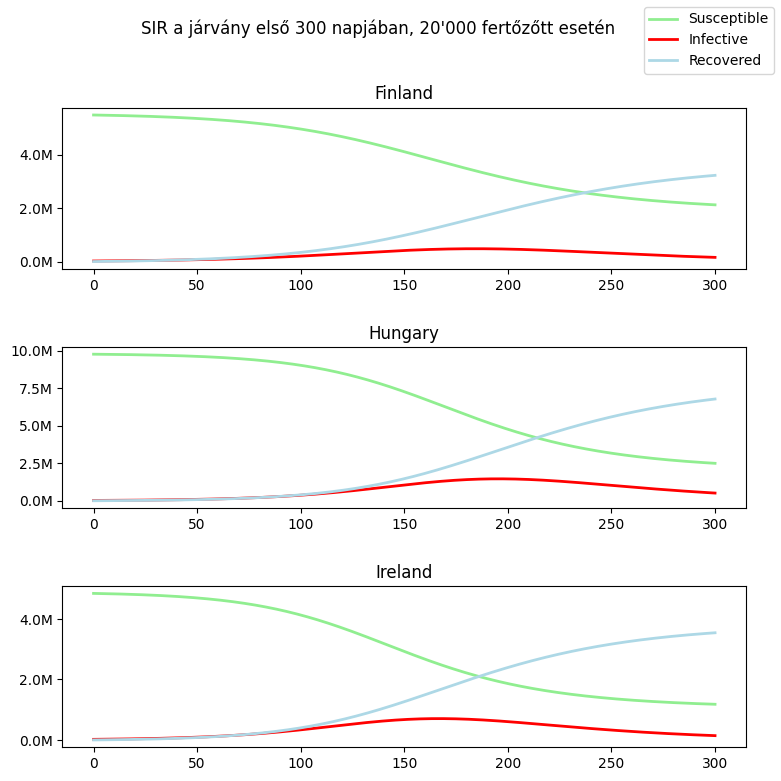

In [9]:
fig, axs = plt.subplots(3,1, figsize=(8,8))
subcountries_indexes=[8,12,13]
counter=0
for j in range(0,3):
    t = np.linspace(0, 300, 300*12)
    sir=sircountry(subcountries_indexes[counter],20000,300)
    axs[j].plot(t, sir[0], lw=2, label='Susceptible', c='lightgreen')
    axs[j].plot(t, sir[1], lw=2, label='Infective', c='red')
    axs[j].plot(t, sir[2], lw=2, label='Recovered', c='lightblue')
    axs[j].set_title(f'{sir_data["Country"][subcountries_indexes[counter]]}')
    axs[j].yaxis.set_major_formatter(formatter)
    counter+=1
    if counter==3:
            axs[2].legend()
            handles, labels = axs[2].get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper right')
            axs[2].legend_ = None

fig.suptitle("SIR a járvány első 300 napjában, 20'000 fertőzőtt esetén")
fig.tight_layout(pad=2.3)